In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal

In [2]:
def gain(sps):
    # Define some constants
    N_bits = 30000 # Number of bits used for timing error analysis
    baud_rate = 9600
    N_syms = N_bits # Number of symbols used for timing error analysis
    tea_sps = 100 # samples/symbol used for timing error analysis
    tea_Fs = tea_sps * baud_rate # sample rate used for timing error analysis
    a_sps = sps # actual samples per symbol used in application
    a_Fs = a_sps * baud_rate # actual sample rate used in application

    # Create rectangular pulse filter
    pf_taps = 1/tea_sps * np.ones(tea_sps)
    pf_len = pf_taps.size
    pf_delay = pf_len/2

    # Generate some bits
    bits = np.random.randint(0, 2, N_bits)

    # Convert the bits to NRZ symbols in [-1, 1]
    symbols = 2*bits-1;

    # Convert symbols to baseband pulses
    x = np.zeros((N_syms * tea_sps))
    x[::tea_sps] = tea_sps * symbols
    baseband = scipy.signal.lfilter(pf_taps, 1, x)

    # Create rectangular matched filter,
    # that's a little too long (7 sps vs 6.667 sps), to introduce more ISI
    #isi_sps = round((tea_sps/a_sps * 7) - tea_sps) # Play with isi samples to see S-curve effects
    isi_sps = 0
    if isi_sps % 2 != 0:
        isi_sps = isi_sps + 1

    mf_taps = 1/(tea_sps+isi_sps) * np.ones(tea_sps+isi_sps)
    mf_len = mf_taps.size
    mf_delay = mf_len/2

    # Matched filter the received baseband pulses
    mf_baseband = scipy.signal.lfilter(mf_taps, 1, baseband);
    mf_baseband = mf_baseband * 1.0 # Play with amplitude to see S-curve effects


    # Symbol centers are now at indices n*tea_sps + isi_sps/2 (I think!)
    # Symbol clock period is tea_sps samples
    # Symbol peaks are perfectly at +/-1.0

    # Timing offset granularity is in 1/tea_sps-th of a symbol
    tau = np.arange(-tea_sps//2+2, tea_sps//2)
    tau_norm = tau/tea_sps*a_sps

    # M&M TED. Contellation points at -1.0 and +1.0.
    # Gardener TED.
    # Perfect estimate of symbol clock period.
    # No external noise.
    mm_ted_output = np.zeros((N_syms, tau.size));
    ga_ted_output = np.zeros((N_syms, tau.size));
    # For each known symbol peak set (M&M needs prev and current symbol)
    for i in range(1, N_syms-1):
        # Cycle through all the timing offsets around this symbol
        # using a perfect symbol clock period estimate
        opt_prev_idx = (i-1)*tea_sps + isi_sps//2;
        opt_curr_idx = i*tea_sps + isi_sps//2;
        for j, t in enumerate(tau):
            prev_soft_sym = mf_baseband[opt_prev_idx - t];
            mid_soft_samp = mf_baseband[(opt_curr_idx+opt_prev_idx)//2 - t];
            curr_soft_sym = mf_baseband[opt_curr_idx - t];
            prev_decision = 1 if prev_soft_sym >= 0 else -1
            curr_decision = 1 if curr_soft_sym >= 0 else -1
            mm_ted_output[i,j] = prev_decision * curr_soft_sym - curr_decision * prev_soft_sym
            ga_ted_output[i,j] = (prev_soft_sym - curr_soft_sym) * mid_soft_samp
        
    mean_mm_ted_output = np.average(mm_ted_output, axis = 0)
    mean_ga_ted_output = np.average(ga_ted_output, axis = 0)

    # Plot the S-Curves
    #plt.figure()
    ##plt.plot()
    ##plt.plot(tau_norm, mean_mm_ted_output)
    ##plt.plot(tau_norm, mean_ga_ted_output)
    #title('S-Curve, 6.667 Samples/Symbol, Rectangular Pulses, Imperfect MF, E_s/N_0 = \infty');
    #xlabel('Timing Error from Symbol Center, \tau_\epsilon (samples)');
    #ylabel('Expected Value of TED Output, E(e[n] | \tau_\epsilon)');
    #grid on;

    # Plot the TED gains
    ##plt.figure()
    tau_diff = tau[:-1]+0.5;
    tau_diff_norm = tau_diff/tea_sps*a_sps;
    diff_mm_ted_output = np.diff(mean_mm_ted_output)/(a_sps/tea_sps);
    diff_ga_ted_output = np.diff(mean_ga_ted_output)/(a_sps/tea_sps);
    ##plt.plot(tau_diff_norm, diff_mm_ted_output)#, '- .b;M and M TED;', ...
    ##plt.plot(tau_diff_norm, diff_ga_ted_output)#, '- +r;Gardner TED;');
    #title('TED Gain, 6.667 Samples/Symbol, Rectangular Pulses, Imperfect MF, E_s/N_0 = \infty');
    #xlabel('Timing Error from Symbol Center, \tau_\epsilon (samples)');
    #ylabel('Timing Error Detector Gain, Slope of E(e[n] | \tau_\epsilon), (sample^{-1})');
    #grid on;

    # Print out the central TED gains
    k = diff_mm_ted_output.size
    mm_ted_gain = np.average(diff_mm_ted_output[(k-1)//2:(k-1)//2+2])
    k = diff_ga_ted_output.size
    ga_ted_gain = np.average(diff_ga_ted_output[(k-1)//2:(k-1)//2+2])
    
    return (mm_ted_gain*sps, ga_ted_gain*sps)

In [3]:
sps = np.arange(2,10.25,0.25)
gains = [gain(s) for s in sps]

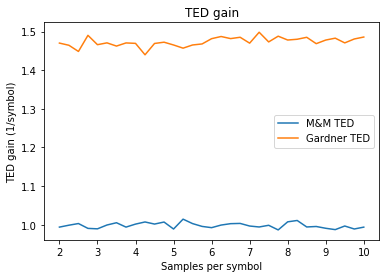

In [4]:
plt.plot(sps, np.array([g[0] for g in gains]))
plt.plot(sps, np.array([g[1] for g in gains]))
plt.title('TED gain')
plt.ylabel('TED gain (1/symbol)')
plt.xlabel('Samples per symbol')
plt.legend(['M&M TED', 'Gardner TED'])

In [5]:
np.average(np.array([g[1] for g in gains]))

1.4733694343435606